In [1]:
from selenium.webdriver.remote.webelement import WebElement
from lavague.evaluator import keep_assignments
import ast

class VariableVisitor(ast.NodeVisitor):
    def __init__(self):
        super().__init__()
        self.output = []
    
    def visit_Assign(self, node):
        
        # For each assignment, print the targets (variables)
        for target in node.targets:
            if isinstance(target, ast.Name):  # Ensure it's a variable assignment
                self.output.append(target.id)

def return_assigned_variables(code_snippet):
    # Parse the code snippet into an abstract syntax tree (AST)
    parsed = ast.parse(code_snippet)
    
    # Create a VariableVisitor object
    visitor = VariableVisitor()
    
    # Visit (i.e., traverse) the AST nodes
    visitor.visit(parsed)
    
    return visitor.output

def get_highlighted_element(generated_code, driver):

    assignment_code = keep_assignments(generated_code)

    code = f"""
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
{assignment_code}
    """.strip()

    local_scope = {"driver": driver}

    exec(code, globals(), local_scope)

    variable_names = return_assigned_variables(generated_code)

    elements = []

    for variable_name in variable_names:
        var = local_scope[variable_name]
        if type(var) == WebElement:
            elements.append(var)
            
    first_element = elements[0]
    driver.execute_script("arguments[0].setAttribute('style', arguments[1]);", first_element, "border: 2px solid red;")
    driver.execute_script("arguments[0].scrollIntoView();", first_element)
    image = Image("screenshot.png")
    return image

print("Hello ")

/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Hello 


In [2]:
from abc import ABC, abstractmethod
from typing import Any
import requests

HF_PROMPT_TEMPLATE = """
You are an AI system whose goal is to generate training examples to teach other AIs to think and reach objectives given by humans and a screenshot of the current page.
The AIs to be taught have to write their thought process and propose an instruction to be performed.
Your answer should contain your thoughts in bullet points, and the instruction for the next step to be performed.
The instruction should be detailled as possible and only contain one step. Do not provide bullet points or multiple steps.
Leverage as much information from the screenshot to make it easy to identify the element, such as placeholders or text.
Do not make assumptions about elements you do not see.
If the objective is already achieved in the screenshot, provide the instruction 'STOP'.

Here are previous examples:
Objective: Ask the AI model 'Command R plus' 'What is love'
Thought: 
- I am on the Hugging Face website. 
- Hugging Face is a company that hosts AI models, and allows users to interact with models on them through the chat.
- Therefore, to answer the objective of asking the AI model 'Command R Plus' 'What is love', we need first to find the model page.
- Given the current screenshot, the fastest way to find the model page seems to be to use the search bar.
Instruction: Type 'Command R plus' on the search bar with placeholder "Search ..." and click on the first result

Objective: Explore the latest updates on the model 'Meta-Llama-3-8B'
Thought:
- I am currently viewing the main page of Hugging Face, a hub for AI models and datasets.
- On this platform, users can explore and interact with a variety of AI models.
- From the current screenshot, I see that the model 'Meta-Llama-3-8B' is displayed in the "Trending" section.
- To investigate the updates made to 'Meta-Llama-3-8B', the best approach is to go directly to the model's specific page where information will be available
Instruction: Click on 'Meta-Llama-3-8B'

Objective: Print installation steps for Hugging Face's Diffusers library
Thought:
- The current page seems to be the home page of the Diffusers' library.
- The installation section is highlighted on the menu on the left-side menu.
- The current page does not provide sufficient information about how to install Diffusers.
- To get more information on installation steps, clicking on the 'Installation' link on the left menu is the best choice.
Instruction: Click on 'Installation', next to 'Effective and efficient diffusion'

Objective: Get information on KANs-base models
Thought:
- The current page is a social post on Hugging Face's website.
- The post is about the recent work of KANs models with GPT2.
- Since this provides sufficient information on KANs, no further action is required to achieve the objective. 
Instruction: STOP

Objective: {objective}
Thought:
"""

class BaseWorldModel(ABC):
    """Abstract class for WorldModel"""

    @abstractmethod
    def get_instruction(self, state: Any, objective: str) -> str:
        """
        Generate the instruction for the agent to reach the objective
        
        Args:
            state: Current state of the world
            objective: Goal to reach
            
        Returns:
            str: Instruction for the agent
        """
        pass

import re

def extract_instruction(text):
    # Use a regular expression to find the content after "Instruction:"
    match = re.search(r"Instruction:\s*(.*)", text)
    if match:
        return match.group(1).strip()  # Return the matched group, stripping any excess whitespace
    else:
        raise ValueError("No instruction found in the text.")


import os
from openai import OpenAI

class GPTWorldModel(BaseWorldModel):
    """Class for Vision-based WorldModel"""
    
    def __init__(self, api_key: str = None, prompt_template: str = HF_PROMPT_TEMPLATE):
        self.prompt_template = prompt_template
        if not api_key:
            api_key = os.getenv("OPENAI_API_KEY")
        if api_key is None:
            raise ValueError("No api_key is provided or OPENAI_API_KEY environment variable is not set")
        self.api_key = api_key
        self.client = OpenAI(api_key=api_key)
    
    def get_instruction(self, state: str, objective: str) -> str:
        base64_image = state
        
        prompt = self.prompt_template.format(objective=objective)

        model = "gpt-4-turbo"
        messages = [
            {
            "role": "user",
            "content": [
                {
                "type": "text",
                "text": prompt
                },
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{base64_image}",
                    "detail": "high"
                }
                }
            ]
            }
        ]
        response  = self.client.chat.completions.create(
            model=model,
            messages=messages,
            max_tokens=300, temperature=0.0
        )

        output = response.choices[0].message.content
        return output

class AzureWorldModel(BaseWorldModel):
    """Class for Vision-based WorldModel"""
    
    def __init__(self, api_key: str, endpoint: str, prompt_template: str = HF_PROMPT_TEMPLATE):
        self.prompt_template = prompt_template
        self.api_key = api_key
        self.endpoint = endpoint
    
    def get_instruction(self, state: str, objective: str) -> str:
        base64_image = state
        headers = {
            "Content-Type": "application/json",
            "api-key": self.api_key,
        }
        
        prompt = self.prompt_template.format(objective=objective)

        # Payload for the request
        payload = {
        "messages": [
            {
            "role": "user",
            "content": [
                {
                "type": "text",
                "text": prompt
                },
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{base64_image}"
                }
                }
            ]
            }
        ],
        "temperature": 0.0,
        "top_p": 0.95,
        "max_tokens": 800
        }
        
        endpoint = self.endpoint

        # Send request
        try:
            response = requests.post(endpoint, headers=headers, json=payload)
            response.raise_for_status()  # Will raise an HTTPError if the HTTP request returned an unsuccessful status code
        except requests.RequestException as e:
            raise SystemExit(f"Failed to make the request. Error: {e}")

        output = response.json()["choices"][0]["message"]["content"]
        return output

In [3]:

world_model = GPTWorldModel()

# import os

# api_key = os.environ["AZURE_OPENAI_VISION_KEY"]
# endpoint = os.environ["AZURE_OPENAI_VISION_ENDPOINT"]

# world_model = AzureWorldModel(api_key, endpoint)

In [4]:
import base64

# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

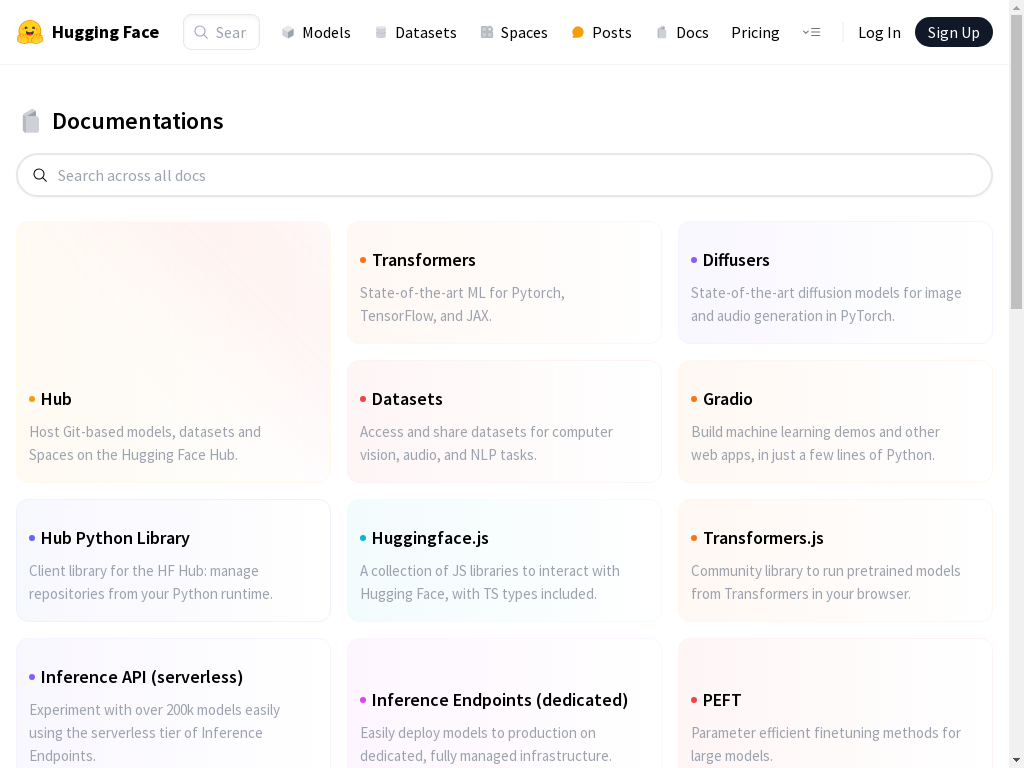

In [5]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
import os.path

chrome_options = Options()
chrome_options.add_argument("--headless")  # Ensure GUI is off
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--window-size=1024,768")

homedir = os.path.expanduser("~")

# Paths to the chromedriver files
path_linux = f"{homedir}/chromedriver-linux64/chromedriver"
path_testing = f"{homedir}/chromedriver-testing/chromedriver"
path_mac = (
    "Google Chrome for Testing.app/Contents/MacOS/Google Chrome for Testing"
)

# To avoid breaking change kept legacy linux64 path
if os.path.exists(path_linux):
    chrome_options.binary_location = f"{homedir}/chrome-linux64/chrome"
    webdriver_service = Service(f"{homedir}/chromedriver-linux64/chromedriver")
elif os.path.exists(path_testing):
    if os.path.exists(f"{homedir}/chrome-testing/{path_mac}"):
        chrome_options.binary_location = f"{homedir}/chrome-testing/{path_mac}"
    # Can add support here for other chrome binaries with else if statements
    webdriver_service = Service(f"{homedir}/chromedriver-testing/chromedriver")
else:
    raise FileNotFoundError("Neither chromedriver file exists.")

driver = webdriver.Chrome(service=webdriver_service, options=chrome_options)

import os
from llama_index.llms.azure_openai import AzureOpenAI
from lavague.retrievers import BM25HtmlRetriever, OpsmSplitRetriever
from lavague.defaults import DefaultEmbedder, DefaultLLM

# api_key=os.getenv("AZURE_OPENAI_KEY")
# api_version="2024-02-15-preview"
# azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
# model = "gpt-35-turbo"
# deployment_name = "gpt-35-turbo"

# from llama_index.llms.azure_openai import AzureOpenAI
# import os

# api_key=os.getenv("AZURE_OPENAI_KEY")
# api_version="2023-05-15"
# azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
# model = "gpt-4"
# deployment_name = "gpt-4-turbo"

# llm = AzureOpenAI(
#     model=model,
#     deployment_name=deployment_name,
#     api_key=api_key,
#     azure_endpoint=azure_endpoint,
#     api_version=api_version,
#     temperature=0.0
# )


# from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# LOCAL_EMBED_MODEL = "BAAI/bge-small-en-v1.5"

# class Embedder(HuggingFaceEmbedding):
#     def __init__(self, model_name: str = LOCAL_EMBED_MODEL, device: str = "cuda"):
#         super().__init__(model_name, device)

# embedder = Embedder()
embedder = DefaultEmbedder()
llm = DefaultLLM()
# opsm_retriever = OpsmSplitRetriever(embedder)
from lavague.action_engine import ActionEngine

bm25_retriever = BM25HtmlRetriever(embedder)
action_engine = ActionEngine(llm, bm25_retriever)

driver.get("https://huggingface.co/docs")
driver.save_screenshot("screenshot.png")

from IPython.display import Image, display
display(Image("screenshot.png"))

  0%|          | 0/5 [00:00<?, ?it/s]

Beginning of a new step


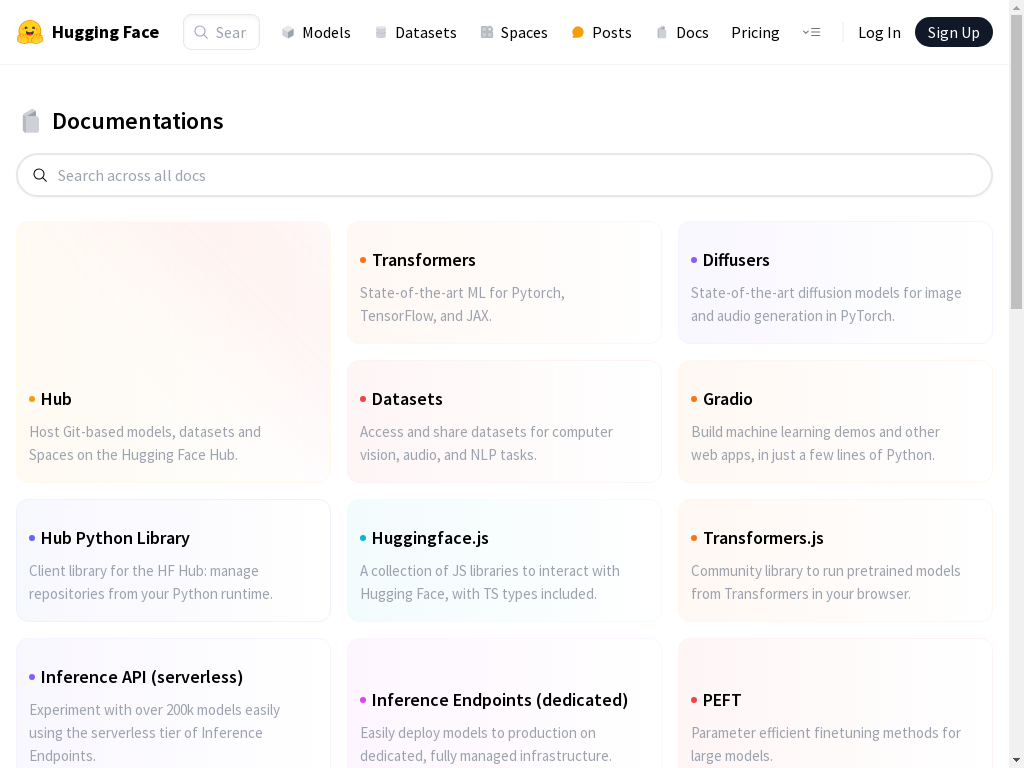

Thoughts: Thought:
- The current screenshot shows the Documentation page of the Hugging Face website.
- The page includes various sections such as Transformers, Datasets, Diffusers, and more.
- The objective is to go on the quick tour of PEFT (Parameter Efficient Fine-Tuning methods for large models).
- The PEFT section is visible in the bottom right corner of the screenshot under the "Documentation" section.

Instruction: Click on 'PEFT' in the bottom right corner of the screenshot.


/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)
  0%|          | 0/5 [00:17<?, ?it/s]

# Based on the provided HTML snippet, the element can be identified using the class "origin-bottom-right"
# Let's use this class with Selenium to identify the element
peft_element = driver.find_element(By.XPATH, """//*[contains(@class,"origin-bottom-right")][contains(@d,"PEFT")][contains(@fill,"#FFD21E")]""")

# Then we can click on the element
peft_element.click()
Error executing action: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[contains(@class,"origin-bottom-right")][contains(@d,"PEFT")][contains(@fill,"#FFD21E")]"}
  (Session info: chrome-headless-shell=122.0.6261.94); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
#0 0x55a6dfb4fe93 <unknown>
#1 0x55a6df847ce6 <unknown>
#2 0x55a6df892e48 <unknown>
#3 0x55a6df892f01 <unknown>
#4 0x55a6df8d63f4 <unknown>
#5 0x55a6df8b4edd <unknown>
#6 0x55a6df8d3899 <unknown>
#7 0x55a6df8b4c53 <unkno

In [7]:
from tqdm import tqdm

objective = "Go on the quicktour of PEFT"
driver.get("https://huggingface.co/docs")
N_retry = 5

for i in tqdm(range(N_retry)):
    driver.save_screenshot("screenshot.png")
    print("Beginning of a new step")
    display(Image("screenshot.png"))
    
    state = encode_image("screenshot.png")
    output = world_model.get_instruction(state, objective)
    
    instruction = extract_instruction(output)
    print("Thoughts:", output)
    if instruction != "STOP":
        query = instruction
        html = driver.page_source

        nodes = action_engine.get_nodes(query, html)
        context = "\n".join(nodes)
        action = action_engine.action_from_context(context, query)
        print(action)
        try:
            screenshot_before_action = get_highlighted_element(action, driver)
            display(screenshot_before_action)
            
            exec(action)
            driver.save_screenshot("screenshot.png")
            display(Image("screenshot.png"))
            
        except Exception as e:
            print(f"Error executing action: {e}")
            break
        print("Step ended")
    else:
        print("Finished")
        break


In [8]:
for node in nodes:
    

"Click on 'PEFT' in the bottom right corner of the screenshot."

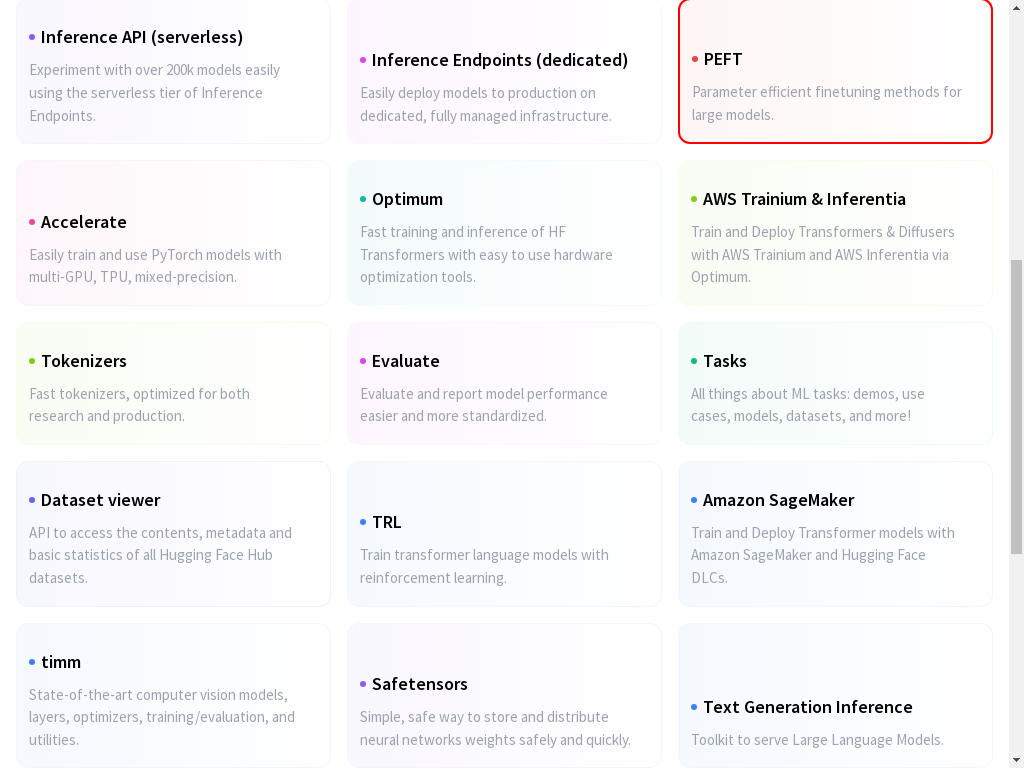

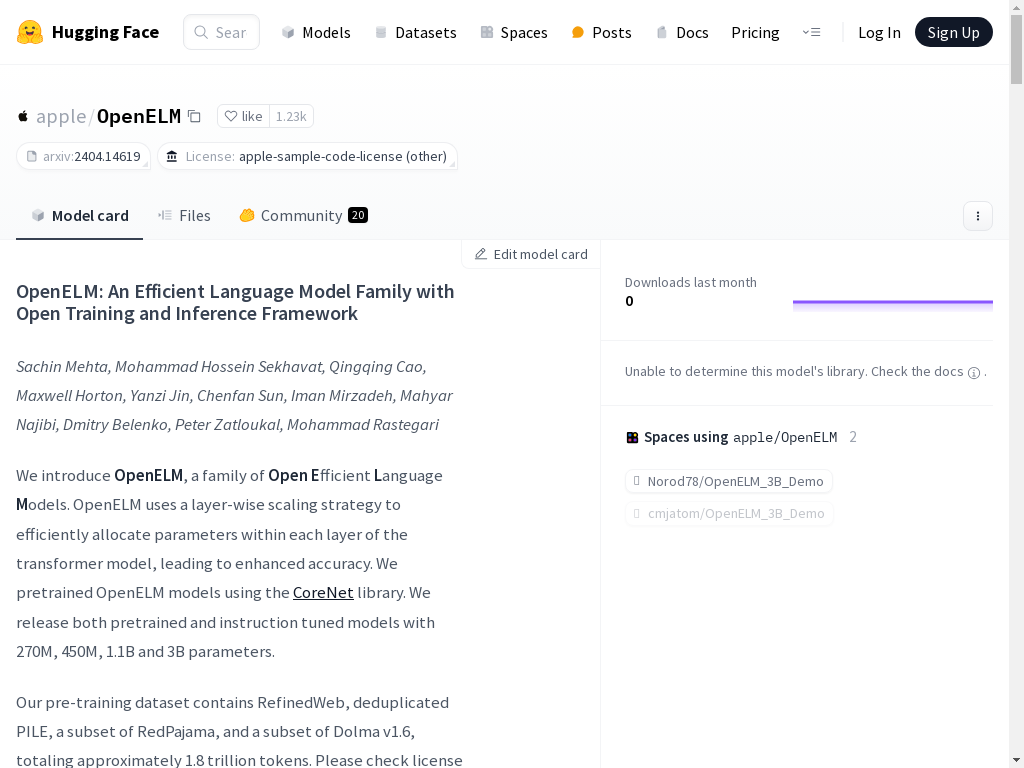

In [6]:
driver.get("https://huggingface.co/apple/OpenELM")
driver.save_screenshot("screenshot.png") 
display(Image("screenshot.png"))

/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


# Let's proceed step by step.
# First we need to identify the code block that contains the installation instructions.

# Based on the HTML provided, we can identify the code block by its class "language-bash"
code_block = driver.find_element(By.XPATH, """//*[contains(@class,"language-bash")]""")

# Now we can print the text inside the code block
print(code_block.text)
# install public lm-eval-harness

harness_repo="public-lm-eval-harness"
git clone https://github.com/EleutherAI/lm-evaluation-harness ${harness_repo}
cd ${harness_repo}
# use main branch on 03-15-2024, SHA is dc90fec
git checkout dc90fec
pip install -e .
cd ..

# 66d6242 is the main branch on 2024-04-01 
pip install datasets@git+https://github.com/huggingface/datasets.git@66d6242
pip install tokenizers>=0.15.2 transformers>=4.38.2 sentencepiece>=0.2.0


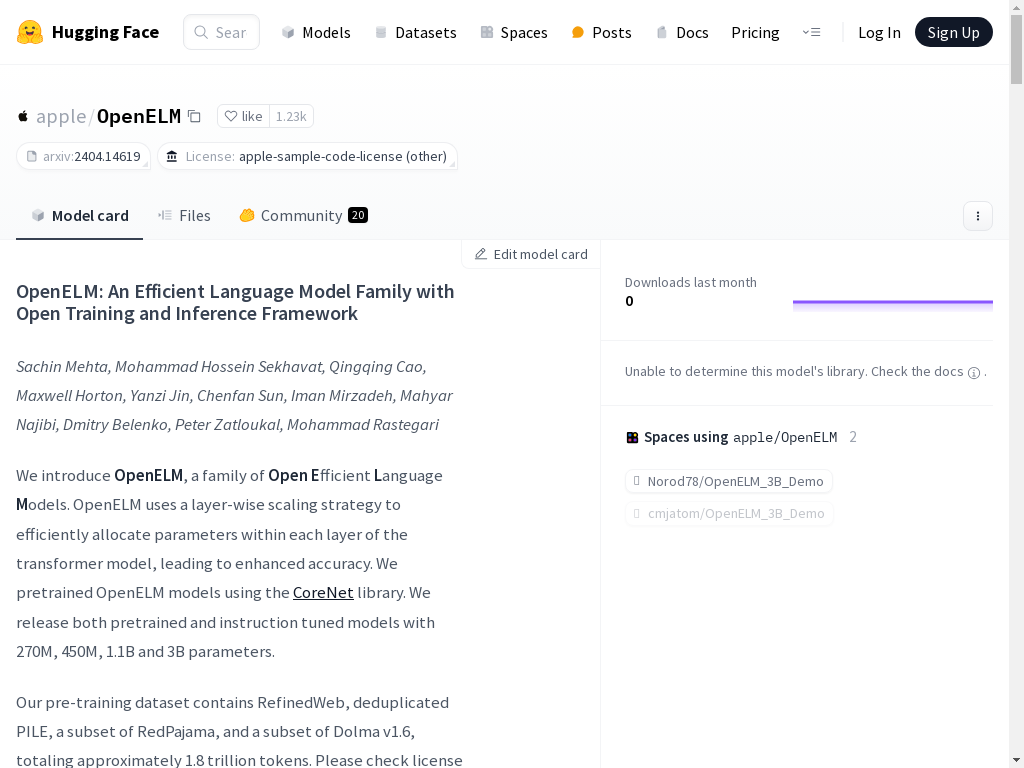

In [7]:
query = "Print the code showing how to install the dependencies"
html = driver.page_source

nodes = action_engine.get_nodes(query, html)
context = "\n".join(nodes)
action = action_engine.action_from_context(context, query)
print(action)

exec(action)
driver.save_screenshot("screenshot.png")
display(Image("screenshot.png"))

In [ ]:
print()

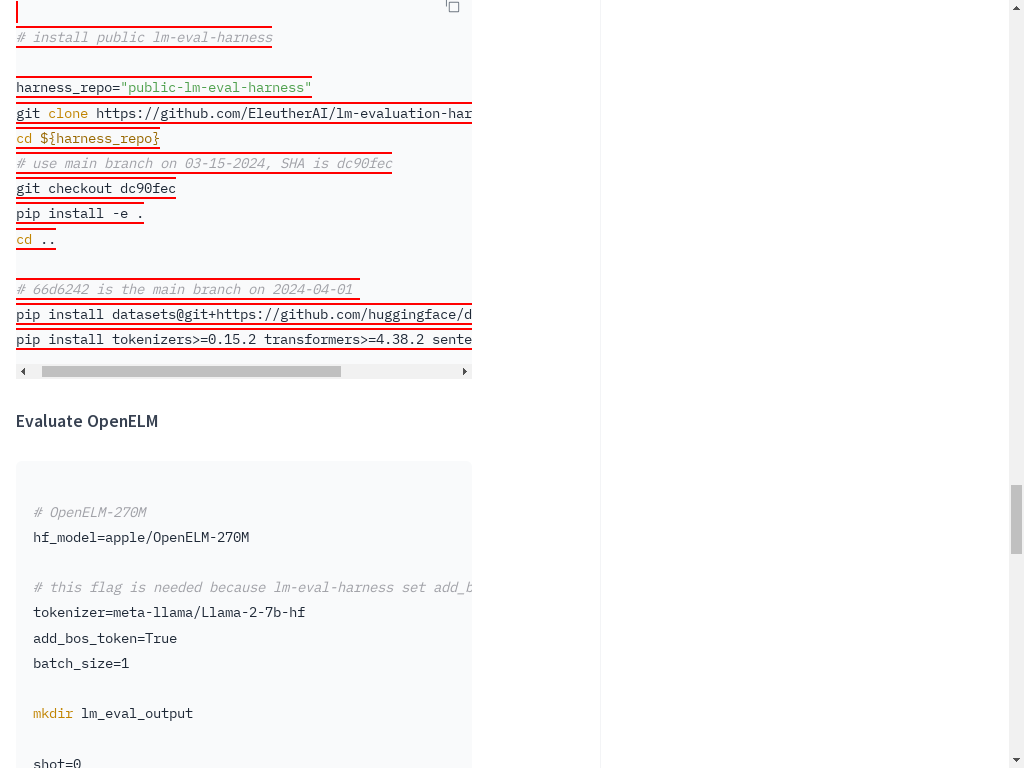

In [15]:


image = get_highlighted_element(action, driver)
display(image)

In [14]:
# Let's proceed step by step.
# First we need to identify the code block that contains the installation instructions.

# Based on the HTML provided, we can identify the code block by its class "language-bash"
code_block = driver.find_element(By.XPATH, """//*[contains(@class,"language-bash")]""")

# Now we can print the text inside the code block
print(code_block.text)

# install public lm-eval-harness

harness_repo="public-lm-eval-harness"
git clone https://github.com/EleutherAI/lm-evaluation-harness ${harness_repo}
cd ${harness_repo}
# use main branch on 03-15-2024, SHA is dc90fec
git checkout dc90fec
pip install -e .
cd ..

# 66d6242 is the main branch on 2024-04-01 
pip install datasets@git+https://github.com/huggingface/datasets.git@66d6242
pip install tokenizers>=0.15.2 transformers>=4.38.2 sentencepiece>=0.2.0


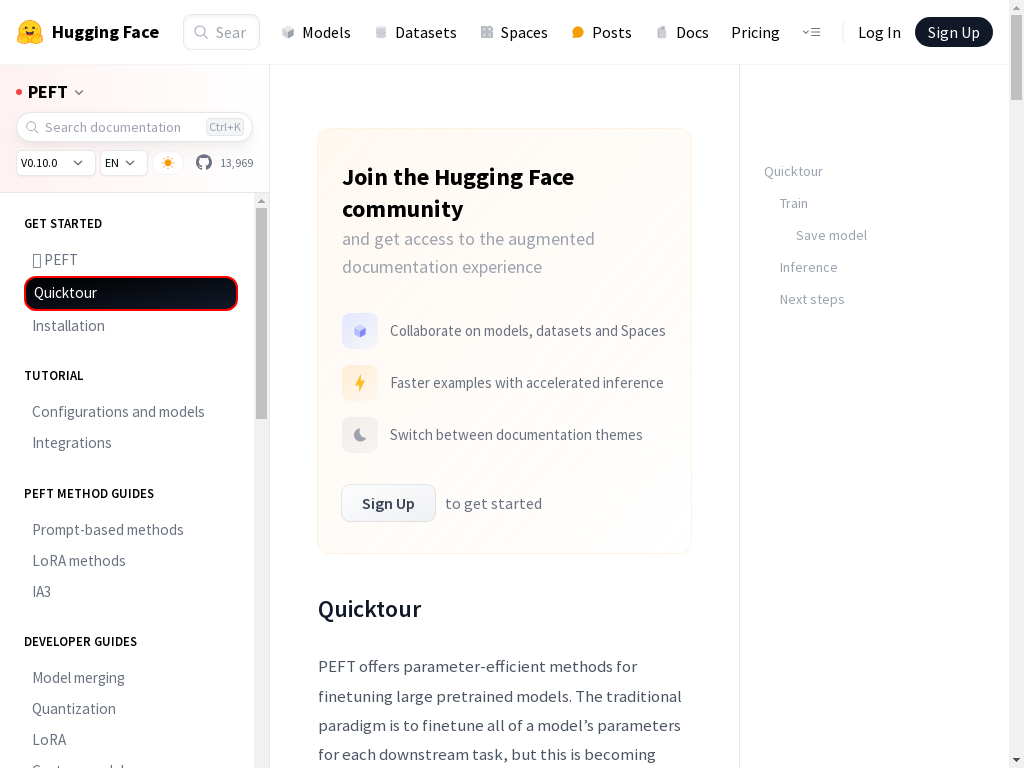

In [12]:
quicktour_link = driver.find_element(By.XPATH, """//*[contains(@id,"quicktour")][contains(@href,"/docs/peft/quicktour")][contains(text(),"Quicktour")]""")

highlight_element(driver, quicktour_link)

In [16]:
from IPython.display import HTML, display, Code

for node in nodes:
    display(HTML(node))

/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


# Let's proceed step by step.
# First we need to identify the 'PEFT' section, then we can click on it.

# Based on the HTML provided, we can identify the 'PEFT' section by the text content 'PEFT'.
# We will use the text content along with other attributes to make sure we target the element precisely.
peft_section = driver.find_element(By.XPATH, """//*[contains(@href,"/docs/peft")][contains(@class,"group")][contains(@class,"relative")][contains(@class,"flex")][contains(@class,"flex-col")][contains(@class,"overflow-hidden")][contains(@class,"border")][contains(@class,"rounded-xl")][contains(@class,"bg-gradient-to-r")][contains(@class,"px-3")][contains(@class,"pb-4")][contains(@class,"pt-6")][contains(@class,"dark:border-gray-900")][contains(@class,"from-red-500/5")][contains(@class,"hover:shadow-alternate")][contains(@class,"to-white")][contains(@class,"shadow-none")][contains(@class,"transition-shadow")][contains(@class,"dark:from-gray-850")][contains(@class,"dark:to-gray-950")][contain

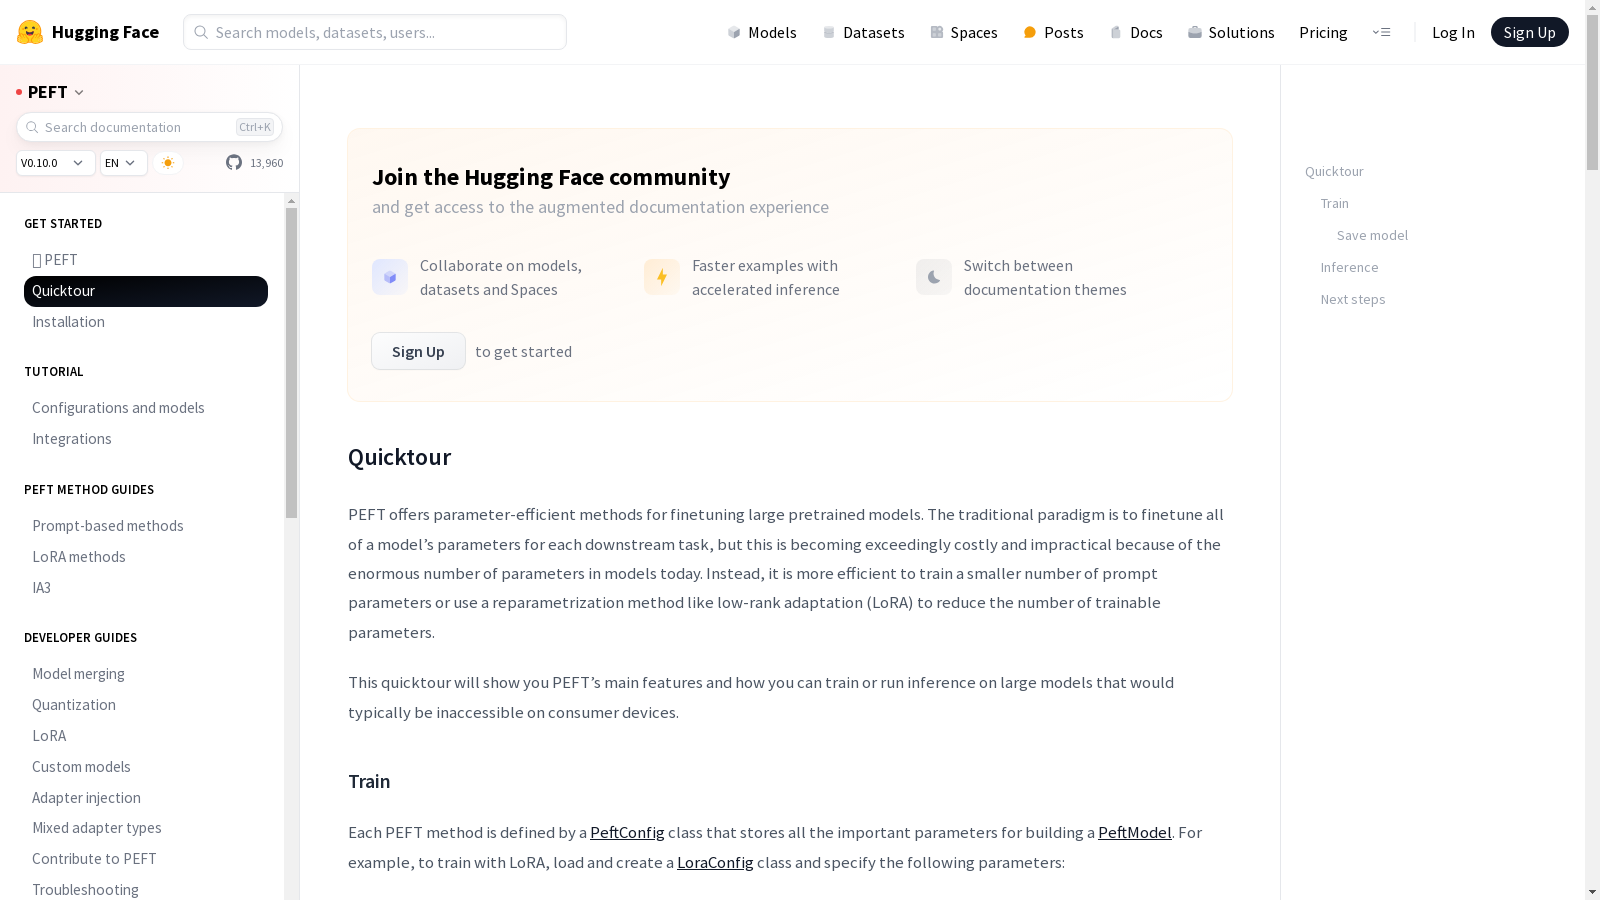

In [19]:
driver.save_screenshot("screenshot.png")
display(Image("screenshot.png"))

In [34]:
query = "Select the text under the 'Quicktour' title and print it"
html = driver.page_source

nodes = action_engine.get_nodes(query, html)
context= "\n".join(nodes)
action = action_engine.action_from_context(context, query)
print(action)

/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


# Let's proceed step by step.
# First we need to identify the element containing the text under the 'Quicktour' title.

# Based on the HTML snippet provided, we can identify the 'Quicktour' title by its href attribute and id.
quicktour_element = driver.find_element(By.XPATH, """//*[contains(@href,"#quicktour")][contains(@id,"nav-quicktour")]""")

# Now we need to get the text from this element.
quicktour_text = quicktour_element.text

# Finally, we print the text.
print(quicktour_text)


In [7]:
from IPython.display import HTML, Code

for node in nodes:
    display(HTML(node))
    display(Code(node, language="html"))

th class="origin-bottom-right transition-transform group-hover:-rotate-6" d=

th class="origin-bottom-left transition-transform group-hover:rotate-6" d=

th class="origin-bottom-right transition-transform group-hover:-rotate-6" d="M38.5967 76.6898C41.3487 72.6538 41.1537 69.6248 37.3777 65.8508C33.6017 62.0778 31.4037 56.5578 31.4037 56.5578C31.4037 56.5578 30.5827 53.3518 28.7127 53.6468C26.8427 53.9418 25.4697 58.7328 29.3867 61.6638C33.3037 64.5938 28.6067 66.5848 27.0997 63.8328C25.5927 61.0808 21.4777 54.0058 19.3437 52.6528C17.2107 51.2998 15.7087 52.0578 16.2117 54.8468C16.7147 57.6358 25.6357 64.3958 24.7677 65.8588C23.8997 67.3208 20.8407 64.1398 20.8407 64.1398C20.8407 64.1398 11.2687 55.4288 9.18465 57.6988C7.10065 59.9688 10.7657 61.8708 15.9887 65.0328C21.2127 68.1938 21.6177 69.0288 20.8767 70.2248C20.1347 71.4208 8.60465 61.6998 7.52165 65.8208C6.43965 69.9418 19.2887 71.1378 18.4957 73.9828C17.7027 76.8288 9.44465 68.5978 7.75565 71.8048C6.06565 75.0128 19.4087 78.7818 19.5167 78.8098C23.8267 79.9278 34.7727 82.2968 38.5967 76.6898Z" fill="#FFD21E"></path><pa

In [35]:
quicktour_element = driver.find_element(By.XPATH, """//*[contains(@href,"#quicktour")][contains(@id,"nav-quicktour")]""")

# Now we need to get the text from this element.
quicktour_text = quicktour_element.text

# Finally, we print the text.
print(quicktour_text)


Quicktour


In [29]:
quicktour_title = driver.find_element(By.XPATH, """//*[contains(@href,"#quicktour")][contains(@id,"nav-quicktour")]""")

# Now we need to get the text of the element. We can use the .text property to retrieve it.
quicktour_text = quicktour_title.text

# Finally, we print the text.
print(quicktour_text)

Quicktour


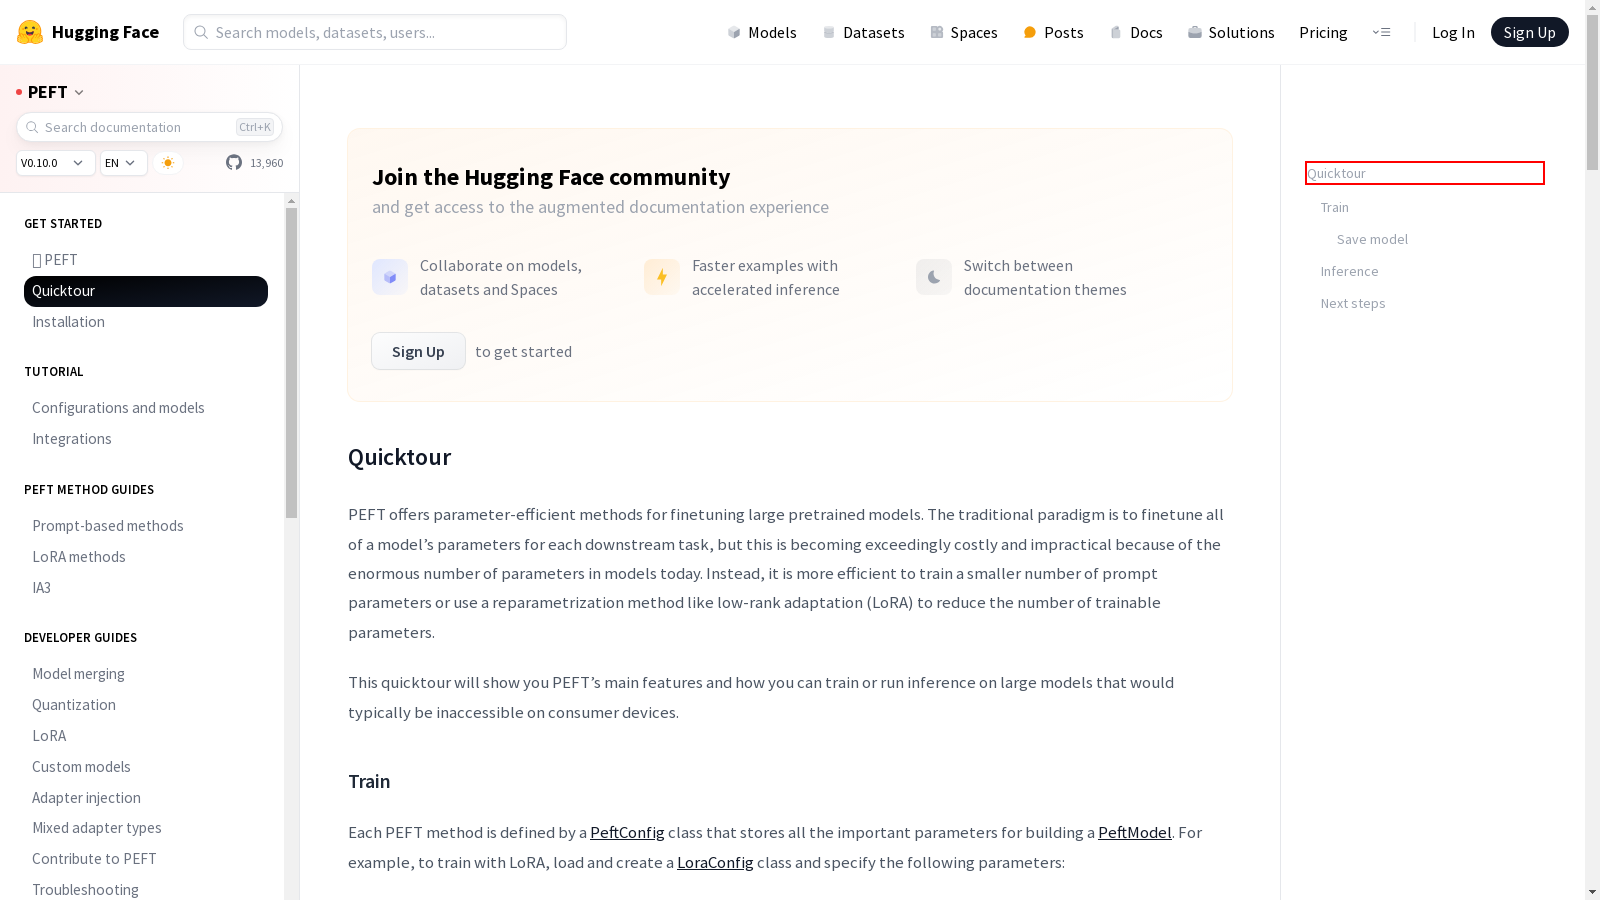

In [27]:
highlight_element(driver, quicktour_link)

In [8]:
def get_bounding_box(element):
    location = element.location
    size = element.size

    # Coordinates
    x_coordinate = location['x']
    y_coordinate = location['y']

    # Size
    width = size['width']
    height = size['height']
    
    box = {
        "x": x_coordinate,
        "y": y_coordinate,
        "width": width,
        "height": height
    }

    return box


def display_bounding_box(element, driver):
    box = get_bounding_box(element)
    from PIL import Image, ImageDraw
    driver.execute_script("arguments[0].scrollIntoView(true);", element)

    driver.save_screenshot("page_screenshot.png")

    image = Image.open("page_screenshot.png")
    draw = ImageDraw.Draw(image)

# Calculate rectangle coordinates
    left = box['x']
    top = box['y']
    right = left + box['width']
    bottom = top + box['height']

    # Draw a rectangle around the element
    draw.rectangle([left, top, right, bottom], outline="red", width=2)

    # Save the modified image
    image.save("highlighted_element.png")

    from IPython.display import Image, display
    display(Image(filename="highlighted_element.png"))

In [10]:
from selenium.webdriver.common.by import By

def get_full_xpath(driver, element):
    parts = []
    while element.tag_name != 'html':
        parent = driver.execute_script('return arguments[0].parentNode;', element)
        siblings = parent.find_elements(By.XPATH, f"./*[name()='{element.tag_name}']")
        count = 0
        index = 1
        for sibling in siblings:
            count += 1
            if sibling == element:
                index = count
        parts.insert(0, f"{element.tag_name}[{index}]")
        element = parent
    parts.insert(0, 'html')  # assuming the root element is always <html>
    full_xpath = '/' + '/'.join(parts)
    return full_xpath

In [19]:
openelm_section.text

''

In [17]:
print(ground_truth_element.text)

OpenELM: An Efficient Language Model Family with Open Training and Inference Framework
Sachin Mehta, Mohammad Hossein Sekhavat, Qingqing Cao, Maxwell Horton, Yanzi Jin, Chenfan Sun, Iman Mirzadeh, Mahyar Najibi, Dmitry Belenko, Peter Zatloukal, Mohammad Rastegari
We introduce OpenELM, a family of Open Efficient Language Models. OpenELM uses a layer-wise scaling strategy to efficiently allocate parameters within each layer of the transformer model, leading to enhanced accuracy. We pretrained OpenELM models using the CoreNet library. We release both pretrained and instruction tuned models with 270M, 450M, 1.1B and 3B parameters.
Our pre-training dataset contains RefinedWeb, deduplicated PILE, a subset of RedPajama, and a subset of Dolma v1.6, totaling approximately 1.8 trillion tokens. Please check license agreements and terms of these datasets before using them.
See the list below for the details of each model:
OpenELM-270M
OpenELM-450M
OpenELM-1_1B
OpenELM-3B
OpenELM-270M-Instruct
Open

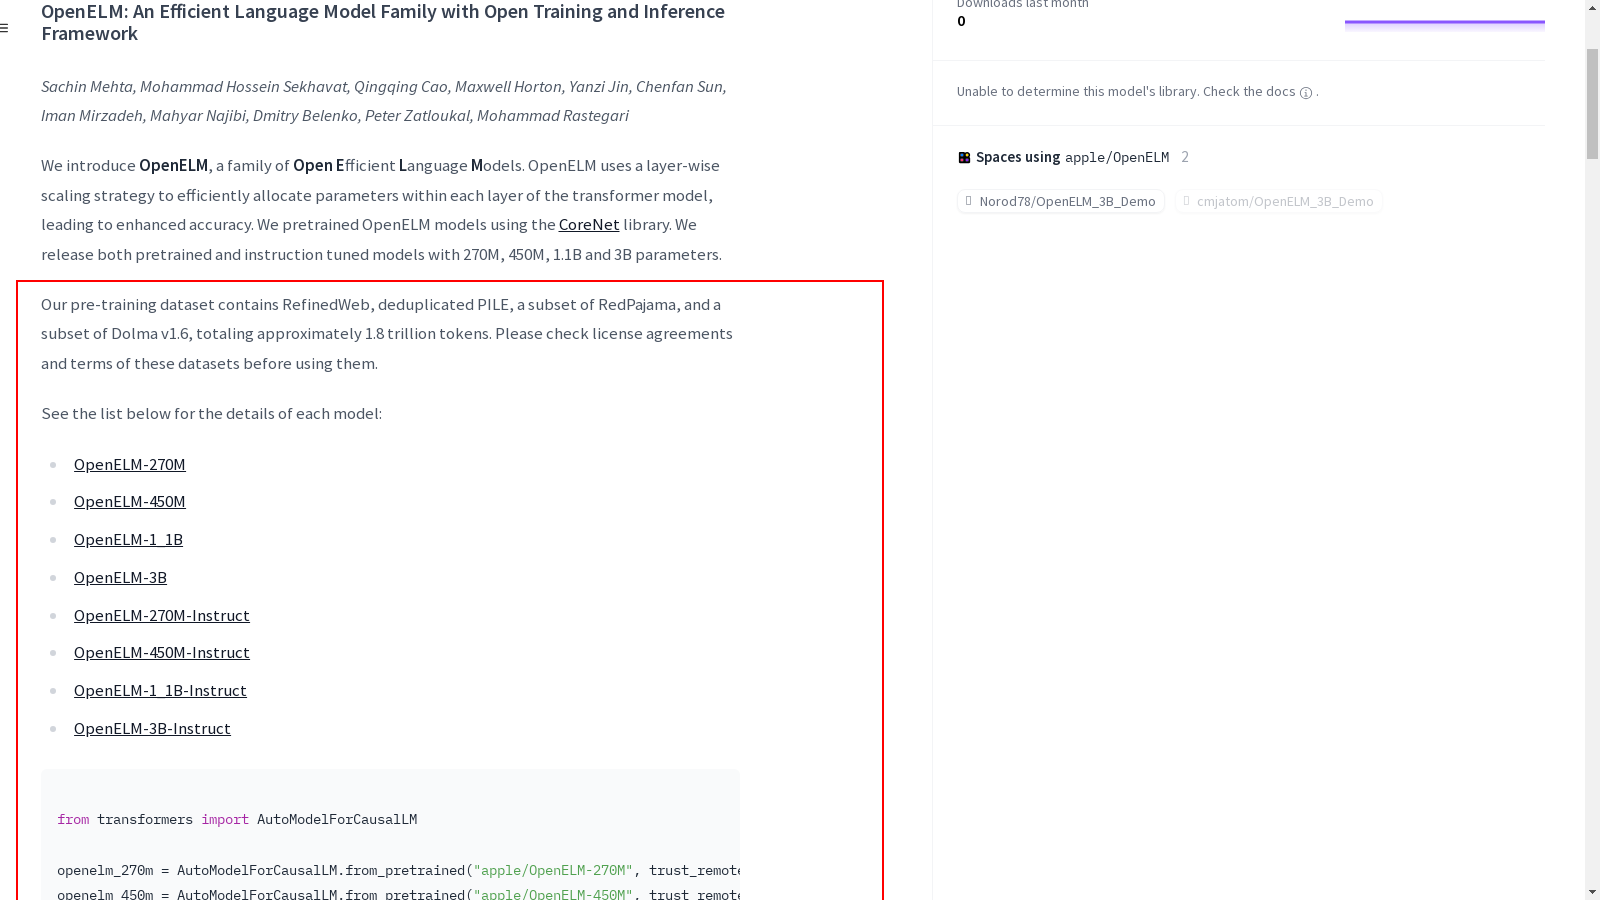

In [15]:
ground_truth_xpath = "/html/body/div[1]/main/div[2]/section[1]/div[3]/div[3]"
ground_truth_element = driver.find_element(By.XPATH, ground_truth_xpath)
display_bounding_box(ground_truth_element, driver)

In [11]:
get_full_xpath(driver, openelm_section)

'/html/body[1]/div[1]/main[1]/div[2]/section[1]/div[3]/div[1]/div[1]/div[1]/div[1]/div[1]/nav[1]/ul[1]/li[1]/a[1]'

In [24]:
driver.get("https://huggingface.co/CohereForAI/c4ai-command-r-plus")

In [27]:
objective = "Type 'What is love?' in the chat box"
expanded_instructions = get_instructions(driver, objective)[0]

In [33]:
expanded_instructions

"Select the input element with placeholder 'Your sentence here...' under the 'Inference API' section, then type 'What is love?'."

In [ ]:
expanded_instructions = "Select the input element with placeholder 'Your sentence here...' under the 'Inference API' section, then type 'What is love?' and press 'Enter'"

In [34]:
html = driver.page_source
expanded_instructions = "Select the input element with placeholder 'Your sentence here...' under the 'Inference API' section, then type 'What is love?' and press 'Enter'"

action = action_engine.get_action(expanded_instructions, html)

/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)
